In [50]:
import nltk
import parselmouth
import numpy as np
import pandas as pd
import os, glob
from tqdm.notebook import tqdm
import statistics
from parselmouth.praat import call
import matplotlib.pyplot as plt
from collections import Counter

## Combine train and test

In [2]:
# load training set
train_df = pd.read_csv("train.csv")
train_df.head(1)

,dialog_id,speaker,transcript,da_tag,start_time,end_time,function,pronoun,ppron,i,...,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler
0,sw2005,A,okay,o,0.0,1.315974,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [3]:
# load testing set
test_df = pd.read_csv("test.csv")
test_df.head(1)

,dialog_id,speaker,transcript,da_tag,start_time,end_time,function,pronoun,ppron,i,...,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler
0,sw2012,A,<noise>,x,0.0,0.451267,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# combine
train_test_df = [train_df, test_df]
train_test_df = pd.concat(train_test_df)
train_test_df.head(3)

,dialog_id,speaker,transcript,da_tag,start_time,end_time,function,pronoun,ppron,i,...,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler
0,sw2005,A,okay,o,0.000000,1.315974,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,1.0,0.000000,0.0
1,sw2005,B,SIL,x,0.000000,10.948825,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,sw2005,A,uh first um i need to know uh how do you feel ...,qo,1.315974,10.930126,0.384615,0.076923,0.076923,0.038462,...,0.076923,0.0,0.0,0.0,0.230769,0.0,0.0,0.0,0.230769,0.0


## Select Audio Feature
for sound I had selected features from HW1, including: Max&Mean&SD pitch, Max&Mean&SD intensity, speaking rate, jitter, shimmer, HNR

In [5]:
def load(path):
    return parselmouth.Sound(path)

In [6]:
# load all sound and their file name using parselmouth
# (filename, sound)
all_sounds = []
counter = 0
path = './HW2_wav_files'
for filename in glob.glob(os.path.join(path, '*.wav')):
    if (counter % 100 == 0):
        print(counter)
    all_sounds.append((filename, load(filename)))
    counter += 1

all_sounds[:10]

0
100
200
300
400
500
600
700
800


[('./HW2_wav_files/sw4733_A.wav', <parselmouth.Sound at 0x7ff5c4ce3f30>),
 ('./HW2_wav_files/sw3223_A.wav', <parselmouth.Sound at 0x7ff5a501cbf0>),
 ('./HW2_wav_files/sw3691_B.wav', <parselmouth.Sound at 0x7ff5a501c570>),
 ('./HW2_wav_files/sw4038_B.wav', <parselmouth.Sound at 0x7ff5a501cab0>),
 ('./HW2_wav_files/sw2104_B.wav', <parselmouth.Sound at 0x7ff5a501cc70>),
 ('./HW2_wav_files/sw3902_B.wav', <parselmouth.Sound at 0x7ff5a501c630>),
 ('./HW2_wav_files/sw2122_A.wav', <parselmouth.Sound at 0x7ff5bbe0d9f0>),
 ('./HW2_wav_files/sw3104_B.wav', <parselmouth.Sound at 0x7ff5a501c830>),
 ('./HW2_wav_files/sw4339_B.wav', <parselmouth.Sound at 0x7ff5a501c2b0>),
 ('./HW2_wav_files/sw2839_A.wav', <parselmouth.Sound at 0x7ff5a501c870>)]

In [22]:
# extract feature from the sounds
'''
    input: all_recordings: have to be a list of (filename, parselmouth sound)
'''
class ExtractProperties:
    def __init__(self, all_recordings):
        self.sounds = list(map(lambda x: x[1], all_recordings))
        
        # extract filename from path
        self.filenames = list(map(lambda x: x[0][16:], all_recordings))
        
    def get_filename(self):
        return self.filenames
    
    def get_pitch(self):
        '''return [Max pitch, Mean pitch, SD pitch]'''
        pitch_info = []
        for i in range(len(self.sounds)):
            sound = self.sounds[i]
            if (i % 100 == 0):
                print(i)
            pitch = list(sound.to_pitch(pitch_floor=75, pitch_ceiling=600).selected_array['frequency'])
            pitch_info.append([round(max(pitch),3), round(statistics.mean(pitch),3), round(statistics.stdev(pitch),3)])
        return pitch_info
    
    def get_intensity(self):
        '''return [Max intensity, Mean intensity, SD intensity]'''
        intensity_info = []
        for i in range(len(self.sounds)):
            sound = self.sounds[i]
            if (i % 100 == 0):
                print(i)
            intensity = list(sound.to_intensity(minimum_pitch=100).values.squeeze())
            intensity_info.append([round(max(intensity),3), round(statistics.mean(intensity),3), round(statistics.stdev(intensity),3)])
        return intensity_info
    
    def get_speaking_rate(self):
        '''
            return speaking rate for each speaker in each audio:
            1- get transcript from dataframe
            2- sum words/total time
        '''
        num_words = []
        for i in range(len(self.filenames)):
            filename = self.filenames[i]
            if (i % 100 == 0):
                print(i)
            # segment the filename
            dialog_id, speaker = filename[:6], filename[7]

            # aggregate all transcripts from df -> count num words
            all_transcripts = train_test_df.loc[train_test_df['dialog_id'] == dialog_id]
            all_transcripts = all_transcripts.loc[all_transcripts['speaker'] == speaker]
            all_transcripts = all_transcripts['transcript']
            total_words = sum(list(map(lambda x: len(x), all_transcripts.tolist())))
            num_words.append(total_words)
            
        # get duration of recording and compute speaking rate
        durations = []
        for i in range(len(self.sounds)):
            sound = self.sounds[i]
            if (i % 100 == 0):
                print(i)
            durations.append(round(sound.get_total_duration(),5))
            
        speaking_rate = [num_words[i]/durations[i] for i in range(len(durations))]
        return speaking_rate
    
    def get_jitter(self):
        jitters = []
        for i in range(len(self.sounds)):
            sound = self.sounds[i]
            if (i % 100 == 0):
                print(i)
            pointProcess = call([sound, sound.to_pitch_ac(pitch_floor=75, pitch_ceiling=600)], "To PointProcess (cc)")
            jitters.append(round(call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3), 3))
        return jitters
    
    def get_shimmer(self):
        shimmer = []
        for i in range(len(self.sounds)):
            sound = self.sounds[i]
            if (i % 100 == 0):
                print(i)
            pointProcess = call([sound, sound.to_pitch_ac(pitch_floor=75, pitch_ceiling=600)], "To PointProcess (cc)")
            localShimmer = call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
            shimmer.append(round(localShimmer, 3))
        return shimmer
    
    def get_hnr(self):
        hnr = []
        for i in range(len(self.sounds)):
            sound = self.sounds[i]
            if (i % 100 == 0):
                print(i)
            harmonicity = call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
            hnr.append(round(call(harmonicity, "Get mean", 0, 0), 2))
        return hnr

In [23]:
# extract properties from each recording
extract_object = ExtractProperties(all_sounds)

In [10]:
print("Computing Pitch...")
pitch_info = extract_object.get_pitch()
print("Finished Pitch...")

Computing Pitch...
0
100
200
300
400
500
600
700
800
Finished Pitch...


In [11]:
print("Computing Intensity...")
intensity_info = extract_object.get_intensity()
print("Finished Intensity...")

Computing Intensity...
0
100
200
300
400
500
600
700
800
Finished Intensity...


In [24]:
print("Computing Speaking rate...")
speaking_rates = extract_object.get_speaking_rate()
print("Finished Speaking rate...")

Computing Speaking rate...
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
Finished Speaking rate...


In [25]:
print("Computing Jitter...")
jitters = extract_object.get_jitter()
print("Computing Jitter...")

Computing Jitter...
0
100
200
300
400
500
600
700
800
Computing Jitter...


In [26]:
print("Computing Shimmer...")
shimmer = extract_object.get_shimmer()
print("Computing Shimmer...")

Computing Shimmer...
0
100
200
300
400
500
600
700
800
Computing Shimmer...


In [27]:
print("Computing HNR...")
hnr = extract_object.get_hnr()
print("Computing HNR...")

Computing HNR...
0
100
200
300
400
500
600
700
800
Computing HNR...


In [28]:
filename = extract_object.get_filename()
dialog_ids, speakers = list(map(lambda x: x[:6], filename)), list(map(lambda x: x[7], filename))

In [29]:
# add each property and create a new dataframe (?)
result = np.concatenate((pitch_info, intensity_info, np.expand_dims(speaking_rates, 1), np.expand_dims(jitters, 1), \
               np.expand_dims(shimmer, 1), np.expand_dims(hnr, 1)), axis=1)

result[0]

array([5.99544000e+02, 5.43340000e+01, 9.89370000e+01, 8.39710000e+01,
       4.73170000e+01, 1.26620000e+01, 1.26218471e+01, 1.00000000e-02,
       7.40000000e-02, 1.53100000e+01])

In [30]:
dataset = pd.DataFrame({'dialog_id': dialog_ids, 'speaker': speakers, \
                        'Max Pitch': result[:, 0], 'Mean Pitch': result[:, 1], \
                        'Sd Pitch': result[:, 2], 'Max Intensity': result[:, 3], \
                        'Mean Intensity': result[:, 4], 'Sd Intensity': result[:, 5], 'Speaking Rate': result[:, 6], \
                        'Jitter': result[:, 7], 'Shimmer': result[:, 8], 'HNR': result[:, 9]})
# .set_index('Speech File')

In [31]:
dataset

,dialog_id,speaker,Max Pitch,Mean Pitch,Sd Pitch,Max Intensity,Mean Intensity,Sd Intensity,Speaking Rate,Jitter,Shimmer,HNR
0,sw4733,A,599.544,54.334,98.937,83.971,47.317,12.662,12.621847,0.010,0.074,15.31
1,sw3223,A,574.822,34.635,75.276,77.292,45.733,15.200,10.702578,0.015,0.105,9.34
2,sw3691,B,596.874,70.514,106.463,78.148,53.440,11.827,10.665515,0.013,0.088,8.26
3,sw4038,B,597.437,26.359,53.780,84.820,18.373,82.753,8.827983,0.014,0.102,9.71
4,sw2104,B,598.148,29.476,70.964,77.184,28.843,23.712,7.960803,0.017,0.080,11.90
...,...,...,...,...,...,...,...,...,...,...,...,...
839,sw2015,B,534.959,24.452,64.533,79.724,38.817,20.903,8.920405,0.011,0.082,12.68
840,sw3813,B,593.223,38.167,69.633,77.602,36.143,50.085,9.324858,0.020,0.102,8.77
841,sw2870,A,599.887,40.809,82.380,76.517,46.294,8.208,6.600446,0.014,0.102,13.72
842,sw2835,A,599.567,77.725,111.791,80.377,11.911,97.290,9.736210,0.014,0.077,14.32


### Save Computed Sound Features

In [32]:
# print to csv
dataset.to_csv('./sound_features.csv')#, index=True)

In [ ]:
# # load sound feature and add to LIWC features
# sound_df = pd.read_csv("sound_features.csv", index_col='Unnamed: 0')
# sound_df

In [ ]:
# left (or inner?) join two tables
# combined_df = train_df.merge(sound_df, on=['dialog_id', 'speaker'], how='left')
# combined_df.head()

In [ ]:
# save the file table
# combined_df.to_csv('./all_features.csv', index=False)

## Preprocessing

All preprocessing steps:
1. Eliminate text LIWC features with total 0 values >= 70
2. Eliminate very short audios (duration < 1)
3. Only keep 10 most common da_tags to make sure the model converge

### Preprocessing Text

We want to eliminate any rows with 0s to:
1. make sure the feature vectors are less sparse -> training will converge faster later
2. lines with most values being 0 aren't helpful for model and us to learn much

This preprocess is only done on training set, not testing set

(array([7.0000e+00, 4.8000e+01, 3.5700e+02, 1.0390e+03, 3.4460e+03,
        5.4310e+03, 1.0239e+04, 9.7540e+03, 1.1042e+04, 8.4020e+03]),
 array([24. , 28.5, 33. , 37.5, 42. , 46.5, 51. , 55.5, 60. , 64.5, 69. ]),
 <BarContainer object of 10 artists>)

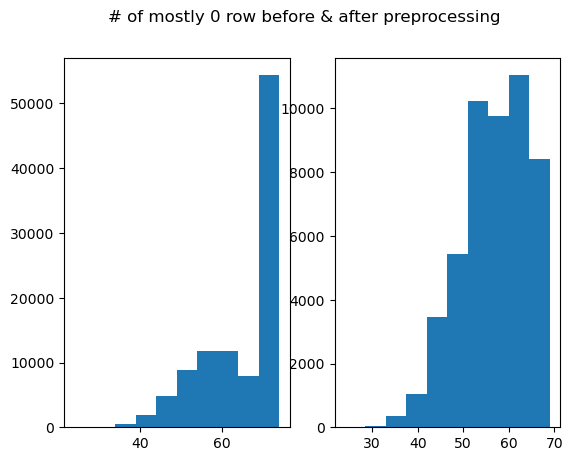

In [35]:
# load unprocessed text features
train_df = pd.read_csv("train.csv")

# eliminate rows that are mostly 0
num_zeros = (train_df == 0).astype(int).sum(axis=1)
num_zeros = pd.DataFrame(num_zeros, columns=['count'])
num_zeros = num_zeros.loc[num_zeros['count'] < 70]
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('# of mostly 0 row before & after preprocessing')
ax1.hist(list((train_df == 0).astype(int).sum(axis=1)))
ax2.hist(num_zeros)

In [36]:
# only keep designated rows from train_df
prep_train_df = num_zeros.merge(train_df, left_index=True, right_index=True, how='left').drop(['count'], axis=1)
prep_train_df.head(1)

,dialog_id,speaker,transcript,da_tag,start_time,end_time,function,pronoun,ppron,i,...,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler
2,sw2005,A,uh first um i need to know uh how do you feel ...,qo,1.315974,10.930126,0.384615,0.076923,0.076923,0.038462,...,0.076923,0.0,0.0,0.0,0.230769,0.0,0.0,0.0,0.230769,0.0


In [37]:
# save the preprocessed text features
prep_train_df.to_csv('./processed_train_text_features.csv')

### Preprocessing Sound

We want to eliminate audios that are very short because they don't give us much information. Since we had already computed all the audio features, and recomputing them takes too long, we use speaking rate (which uses recording duration as nominator) to eliminate short audios.

In [38]:
# load sound feature and add to LIWC features
sound_df = pd.read_csv("sound_features.csv", index_col='Unnamed: 0')
sound_df.head()

,dialog_id,speaker,Max Pitch,Mean Pitch,Sd Pitch,Max Intensity,Mean Intensity,Sd Intensity,Speaking Rate,Jitter,Shimmer,HNR
0,sw4733,A,599.544,54.334,98.937,83.971,47.317,12.662,12.621847,0.010,0.074,15.31
1,sw3223,A,574.822,34.635,75.276,77.292,45.733,15.200,10.702578,0.015,0.105,9.34
2,sw3691,B,596.874,70.514,106.463,78.148,53.440,11.827,10.665515,0.013,0.088,8.26
3,sw4038,B,597.437,26.359,53.780,84.820,18.373,82.753,8.827983,0.014,0.102,9.71
4,sw2104,B,598.148,29.476,70.964,77.184,28.843,23.712,7.960803,0.017,0.080,11.90


In [39]:
# eliminate any speaking rate == 0 and resave the features
sound_df = sound_df.loc[sound_df['Speaking Rate'] > 0]
sound_df.to_csv('./processed_sound_features.csv')

### Recombine dataframe after preprocessing (Train)

Since we had performed inner join of two tables, we eliminate any LIWC without audio features and audio without transcripts:

In [81]:
# load both text and sound feature dataframes
sound_df = pd.read_csv("processed_sound_features.csv", index_col='Unnamed: 0')
text_df = pd.read_csv("processed_train_text_features.csv", index_col='Unnamed: 0')

In [82]:
# inner join two tables to create final training set
combined_df = text_df.merge(sound_df, on=['dialog_id', 'speaker'], how='inner')

# only keep features we are going to use
features_to_discard = ['transcript', 'start_time', 'end_time']
combined_df = combined_df.drop(features_to_discard, axis=1)

In [83]:
# save unfiltered
combined_df.to_csv('./combined_processed_train.csv')
combined_df.head(1)

,dialog_id,speaker,da_tag,function,pronoun,ppron,i,we,you,shehe,...,Max Pitch,Mean Pitch,Sd Pitch,Max Intensity,Mean Intensity,Sd Intensity,Speaking Rate,Jitter,Shimmer,HNR
0,sw2005,A,qo,0.384615,0.076923,0.076923,0.038462,0.0,0.038462,0.0,...,561.691,23.98,50.946,81.406,39.0,23.787,10.196142,0.016,0.087,13.45


#### Filter uncommon tags

To improve training performance, we choose 10 most common tags to predict and train:

In [84]:
# Choose only top 15 tags to predict, remove other tags
dict_occ = Counter(list(combined_df['da_tag'])).most_common(10)
most_common_tags = list(map(lambda x: x[0], dict_occ))
print(most_common_tags)

# remove other tags from dataframe
combined_df = combined_df[combined_df.apply(lambda x: x['da_tag'] in most_common_tags, axis=1)]

['sd', 'sv', '+', '%', 'aa', 'qy', 'ba', 'b', 'sd^e', 'qw']


In [85]:
# save filtered
combined_df.to_csv('./combined_processed_train_filtered.csv')
combined_df.head(1)

,dialog_id,speaker,da_tag,function,pronoun,ppron,i,we,you,shehe,...,Max Pitch,Mean Pitch,Sd Pitch,Max Intensity,Mean Intensity,Sd Intensity,Speaking Rate,Jitter,Shimmer,HNR
1,sw2005,A,sd,0.65,0.2,0.15,0.1,0.0,0.0,0.05,...,561.691,23.98,50.946,81.406,39.0,23.787,10.196142,0.016,0.087,13.45


### Recombine dataframe after preprocessing (Test)

In [86]:
# load unprocessed text and sound features
sound_df = pd.read_csv("processed_sound_features.csv", index_col='Unnamed: 0')
test_df = pd.read_csv("test.csv")

In [87]:
# inner join two tables to create final testing set
combined_df = test_df.merge(sound_df, on=['dialog_id', 'speaker'], how='inner')

# only keep features we are going to use
features_to_discard = ['transcript', 'start_time', 'end_time']
combined_df = combined_df.drop(features_to_discard, axis=1)

# save unfiltered
combined_df.to_csv('./combined_processed_test.csv')
combined_df.head(1)

,dialog_id,speaker,da_tag,function,pronoun,ppron,i,we,you,shehe,...,Max Pitch,Mean Pitch,Sd Pitch,Max Intensity,Mean Intensity,Sd Intensity,Speaking Rate,Jitter,Shimmer,HNR
0,sw2022,A,x,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,593.312,46.962,95.457,83.295,45.533,13.209,10.30899,0.013,0.087,13.45


#### Filter uncommon tags

In [88]:
# Choose only top 15 tags to predict, remove other tags
# remove other tags from dataframe
combined_df = combined_df[combined_df.apply(lambda x: x['da_tag'] in most_common_tags, axis=1)]

# save filtered
combined_df.to_csv('./combined_processed_test_filtered.csv')
combined_df.head(1)

,dialog_id,speaker,da_tag,function,pronoun,ppron,i,we,you,shehe,...,Max Pitch,Mean Pitch,Sd Pitch,Max Intensity,Mean Intensity,Sd Intensity,Speaking Rate,Jitter,Shimmer,HNR
2,sw2022,A,%,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,593.312,46.962,95.457,83.295,45.533,13.209,10.30899,0.013,0.087,13.45


## Analysis & Hypothesis

### LIWC Analysis

Hypothesis: Hypothesis that value certain in LIWC can help predict whether the speaker is asking a question or not. If the user is more certain, the speaker is more unlikely to be asking a question, and less certain the user is, the more likely they are asking a question. Thus, we could use it to predict dialog act such as Yes-No-Question (qy), wh-question(qw), Rhetorical-Questions (qh), and Open-Question (qo).

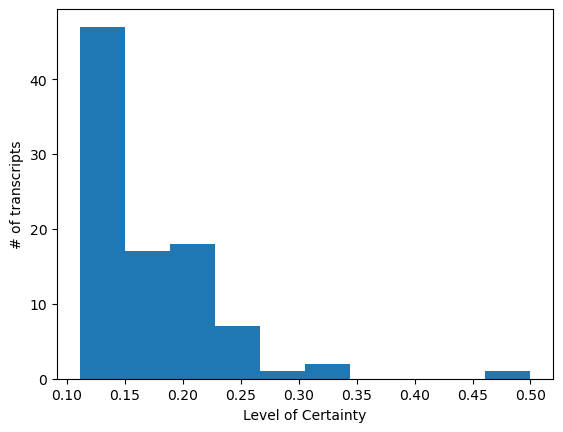

In [89]:
selected = prep_train_df[['certain', 'da_tag']].loc[train_df['certain'] > 0.1]
question_tag = ['qy', 'qw', 'qh', 'qo', 'qh', 'qw^d']
selected = selected[selected.apply(lambda x: x['da_tag'] in question_tag, axis=1)]

# create a plot: level of certainty and number of tags
plt.hist(selected['certain'])
plt.xlabel("Level of Certainty")
plt.ylabel("# of transcripts")
plt.show()

And some tags such as Agree/Accept(aa), Statement-non-opinion(sd), Response Acknowledgement(bk), and Affirmative non-yes answers(na), might have high level of certainty.

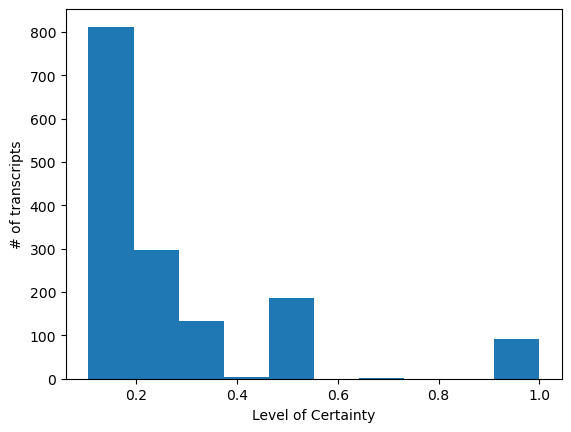

In [90]:
selected = prep_train_df[['certain', 'da_tag']].loc[train_df['certain'] > 0.1]
affirm_tag = ['aa', 'sd', 'bk', 'na']
selected = selected[selected.apply(lambda x: x['da_tag'] in affirm_tag, axis=1)]

plt.hist(selected['certain'])
plt.xlabel("Level of Certainty")
plt.ylabel("# of transcripts")
plt.show()

We can see that from the two graph above, even through the noise of huge number of transcripts below 0.2, the number of transcripts with "certainy tags" does have more transcripts in higher level of certainty region (>0.8). The "uncertain tag" doesn't have any transcripts > 0.8. However, the certain value seems bit noisy (where there is lots of 0s).

### Sound Analysis

Hypothesis: Average and max intensity will be correspond to emotions. We want to test the relationship between average and max intensity with agree/accept(aa), Appreciation(ba), Reject(ar), Apology(fa), Thanking(ft).

In [91]:
# load combined dataset features
combined_df = pd.read_csv("combined_processed_train.csv", index_col='Unnamed: 0')
combined_df.head(2)

,dialog_id,speaker,da_tag,function,pronoun,ppron,i,we,you,shehe,...,Max Pitch,Mean Pitch,Sd Pitch,Max Intensity,Mean Intensity,Sd Intensity,Speaking Rate,Jitter,Shimmer,HNR
0,sw2005,A,qo,0.384615,0.076923,0.076923,0.038462,0.0,0.038462,0.00,...,561.691,23.98,50.946,81.406,39.0,23.787,10.196142,0.016,0.087,13.45
1,sw2005,A,sd,0.650000,0.200000,0.150000,0.100000,0.0,0.000000,0.05,...,561.691,23.98,50.946,81.406,39.0,23.787,10.196142,0.016,0.087,13.45


In [92]:
selected = combined_df[['da_tag', 'Max Intensity', 'Mean Intensity']]
selected_aa, selected_ba, selected_ar, selected_fa, selected_ft = \
selected.loc[selected['da_tag'] == 'aa'], \
selected.loc[selected['da_tag'] == 'ba'], \
selected.loc[selected['da_tag'] == 'ar'], \
selected.loc[selected['da_tag'] == 'fa'], \
selected.loc[selected['da_tag'] == 'ft'], 

In [93]:
# compute mean for max and mean intensity: [avg max intensity, avg mean intensity]
mean_aa = [statistics.mean(list(selected_aa['Max Intensity'])), statistics.mean(list(selected_aa['Mean Intensity']))]
mean_ba = [statistics.mean(list(selected_ba['Max Intensity'])), statistics.mean(list(selected_ba['Mean Intensity']))]
mean_ar = [statistics.mean(list(selected_ar['Max Intensity'])), statistics.mean(list(selected_ar['Mean Intensity']))]
mean_fa = [statistics.mean(list(selected_fa['Max Intensity'])), statistics.mean(list(selected_fa['Mean Intensity']))]
mean_ft = [statistics.mean(list(selected_ft['Max Intensity'])), statistics.mean(list(selected_ft['Mean Intensity']))]
all_means = [mean_aa, mean_ba, mean_ar, mean_fa, mean_ft]

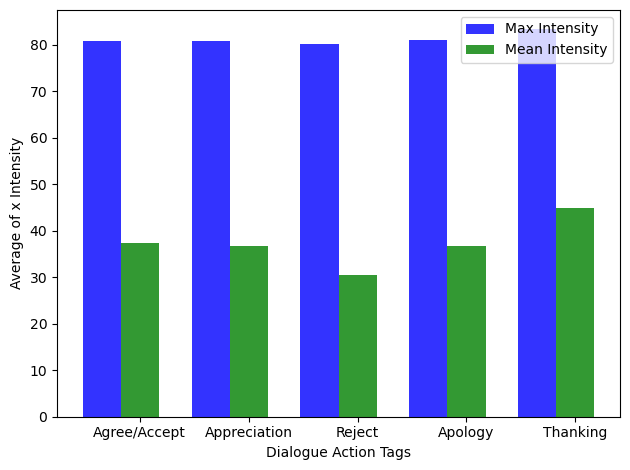

In [94]:
# make graph DA tag vs intensity
# data to plot
n_groups = 5
means_frank = [x[0] for x in all_means]
means_guido = [x[1] for x in all_means]

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, means_frank, bar_width,
alpha=opacity,
color='b',
label='Max Intensity')

rects2 = plt.bar(index + bar_width, means_guido, bar_width,
alpha=opacity,
color='g',
label='Mean Intensity')

plt.xlabel('Dialogue Action Tags')
plt.ylabel('Average of x Intensity')
plt.xticks(index + bar_width, ('Agree/Accept', 'Appreciation', 'Reject', 'Apology', 'Thanking'))
plt.legend()

plt.tight_layout()
plt.show()

Conclusion: We can see reject has lowest mean and max intensity and thanking has highest mean and max intensity. However, apology, agree/acept and appreciation has similar mean and max intensity. Thus, we could infer some amount of dialogue action tag from levels of intensity, but to predict dialogue action tags, we could not depend on intensity alone.